In [1]:
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
#pv.OFF_SCREEN=True

In [2]:
import os, numpy as np, xarray as xr

import cedalion
import cedalion.io as cio
import cedalion.datasets
import cedalion.imagereco.forward_model as fw
import cedalion.geometry.segmentation as cgeoseg
import cedalion.geometry.registration as cgeoreg
import cedalion.plots as cp
 
import cedalion.geometry.landmarks as cgeolm
from cedalion.imagereco.solver import pseudo_inverse_stacked

## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain. Oh no, that's broken atm, so let's use the ICBM-152.

In [3]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
SEG_DATADIR = '/Users/nilsharmening/Projects/heads/colin27_cedalion_ras'
landmarks_file = 'fiducials_ijk.mrk.json'
masks, t_ijk2ras = cedalion.io.read_segmentation_masks(SEG_DATADIR, mask_files)

In [4]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()
masks, t_ijk2ras = cedalion.io.read_segmentation_masks(SEG_DATADIR, mask_files)

## The OneSurfaceFewVoxelsHeadModel

The photon propagation considers the complete MRI scan, in which each voxel is attributed to one tissue type with its respective optical properties. However, the image reconstruction does not intend to reconstruct absorption changes in each voxel. The inverse problem is simplified, by considering only one surface (scalp) and few voxels (brain) and reconstructing only absorption changes in those voxels. The few brain voxels are those closer than `max_dist` (in mm) to the scalp surface (gauge depending on the source-detector-distances). This can be reduced by taking a registered probe into account and considering only those voxels _close enough_ to the optodes as important. After simulating the photon transportation, the number of voxels can even be further reduced to those brain voxels, that are _sensitive enough_ to the channels.

The class `cedalion.imagereco.forward_model.OneSurfaceFewVoxelsHeadModel` groups together the segmentation mask, affine transformations, the scalp surface and the important brain voxels.

In [5]:
# Construct voxel headmodel 
head = fw.OneSurfaceFewVoxelsHeadModel.from_segmentation(
        segmentation_dir=SEG_DATADIR,
        mask_files = mask_files,
        landmarks_ras_file=landmarks_file,
        max_dist = 50#mm depth 
    )

Compared to class `cedalion.imagereco.forward_model.TwoSurfaceHeadModel` only `brain` is different (not a surface but voxels):

In [6]:
head.brain

Voxels(voxels=array([[ 25.,  95., 144.],
       [ 25.,  95., 145.],
       [ 25.,  95., 146.],
       ...,
       [167., 101., 144.],
       [167., 101., 145.],
       [167., 102., 144.]]), crs='ijk', units=<Unit('dimensionless')>)

# Visualize all voxels

1517548 1517548


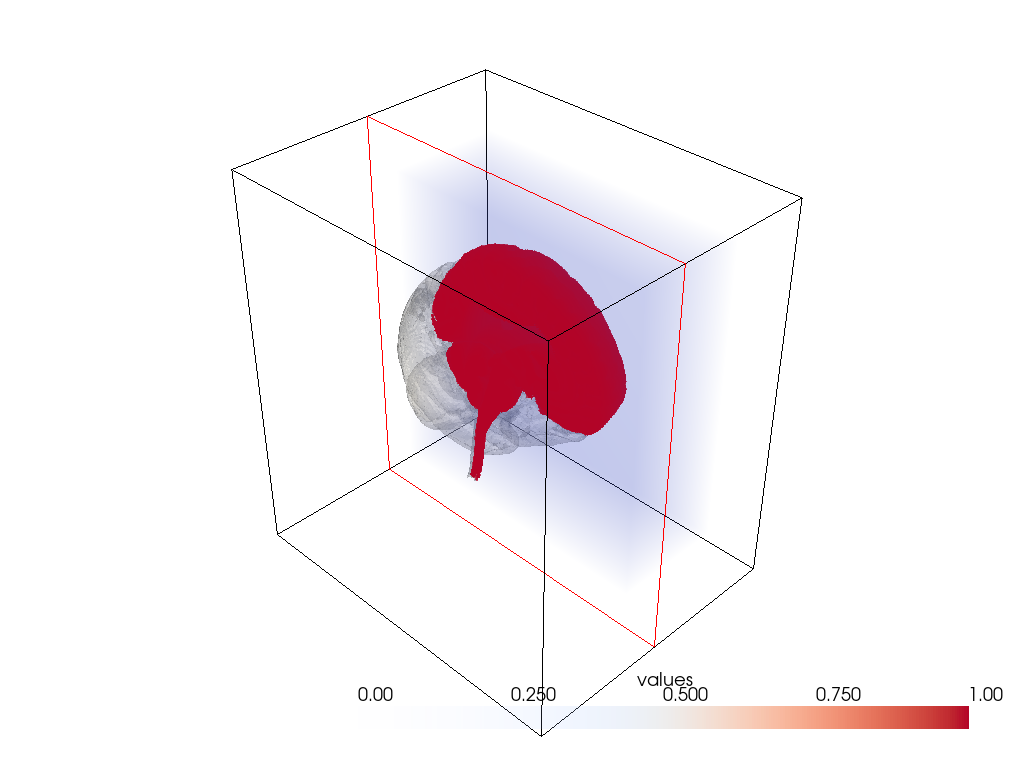

In [7]:
# only to get the brain surface
TwoSurfHM = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)

# Prepare the brain voxels contained in the HM for plotting by assigning them the value 1.0 
shape = head.segmentation_masks.shape[-3:]
brain_voxels = np.zeros(shape)
brain_voxels_reduced = brain_voxels.flatten() @ head.voxel_to_few_voxel_brain
brain_voxels_reduced[:] = 1.0 # set to 1 to make them visible
# to remove active voxels if they are not brain 
brain_voxels = (head.voxel_to_few_voxel_brain @ brain_voxels_reduced).reshape(brain_voxels.shape)
print(np.sum(brain_voxels==1.0), head.brain.nvertices)


# Plot
plt = pv.Plotter()
vf = pv.wrap(brain_voxels)

plt.add_volume_clip_plane(
    vf,
    log_scale=False, 
    cmap="coolwarm",
    normal='-x',
    interaction_event='always',
    normal_rotation=False,
    opacity='sigmoid_5'
)

cedalion.plots.plot_surface(plt, TwoSurfHM.brain, color="w", opacity=0.3)

plt.show()

## Reduce voxels to probe registration 
The head model contains a lot of brain voxels that will never be sensitive to a given probe (especially if the montage is covering only parts of the head). If a registered probe is available, it can be used to reduce the number of contained voxels in the head model significantly.

### Load digitized probe

In [8]:
rec = cedalion.datasets.get_fingertapping()
geo3d_meas = rec.geo3d
geo3d_meas = geo3d_meas.pint.to(cedalion.units.mm)
#cedalion.plots.plot_montage3D(rec["amp"], geo3d_meas)

# We know that 'digitized' is ijk
display(geo3d_meas.points.crs)
geo3d_meas = geo3d_meas.points.set_crs('ijk')
display(geo3d_meas.points.crs)

# Align and scap to head model
geo3d_snapped_ijk = head.align_and_snap_to_scalp(geo3d_meas)

'digitized'

'ijk'

/usr/local/lib/python3.10/site-packages/xarray/namedarray/core.py:487: UserWarning: Duplicate dimension names present: dimensions {'ijk'} appear more than once in dims=('ijk', 'ijk'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(


### Plot aligned and snapped optodes

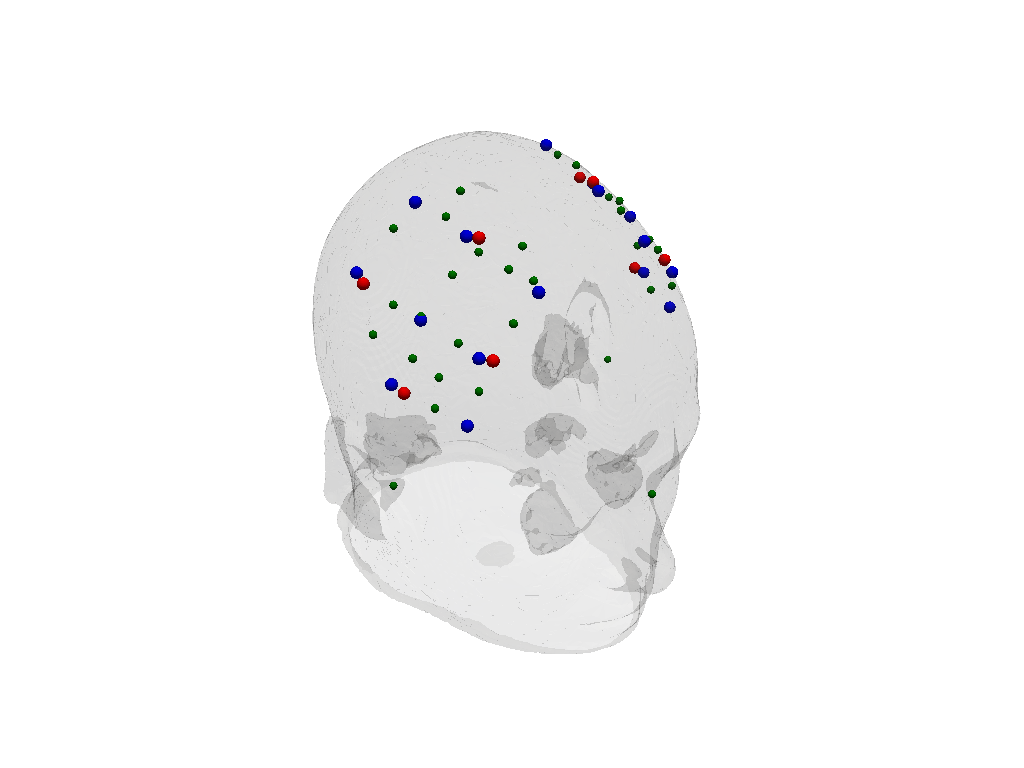

In [9]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

### Reduce the number of voxels by using a registered probe

In [10]:
head.brain.units = cedalion.units.mm
head = head.reduce_voxels_to_probe(geo3d_snapped_ijk, max_dist=50)

/usr/local/lib/python3.10/site-packages/xarray/core/variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Reduced 1517548 brain voxels to 724315 (ratio: 0.480000).


724315 724315


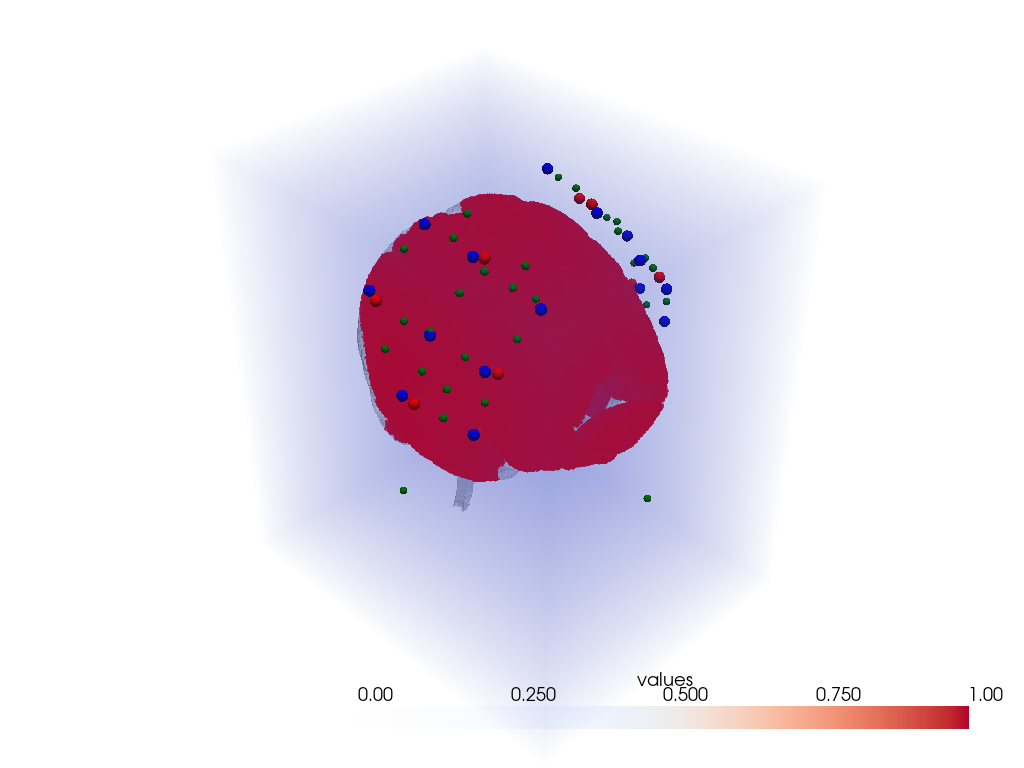

In [11]:
# Prepare the brain voxels contained in the HM for plotting by assigning them the value 1.0 
shape = head.segmentation_masks.shape[-3:]
brain_voxels = np.zeros(shape)
brain_voxels_reduced = brain_voxels.flatten() @ head.voxel_to_few_voxel_brain
brain_voxels_reduced[:] = 1.0 # set to 1 to make them visible
# to remove active voxels if they are not brain 
brain_voxels = (head.voxel_to_few_voxel_brain @ brain_voxels_reduced).reshape(brain_voxels.shape)
print(np.sum(brain_voxels==1.0), head.brain.nvertices)


# Plot
plt = pv.Plotter()
vf = pv.wrap(brain_voxels)

plt.add_volume(
    vf,
    log_scale=False,
    cmap="coolwarm",
    opacity='sigmoid_5'
)

cedalion.plots.plot_surface(plt, TwoSurfHM.brain, color="w", opacity=0.3)

cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)#, show_labels=False)
plt.show()

## Photon transport simulation

In [17]:
# Construct forward model
meas_list = rec._measurement_lists["amp"]
# correct the indices to start at 0 
meas_list.sourceIndex -= 1
meas_list.detectorIndex -= 1
meas_list.wavelengthIndex -= 1
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, meas_list)

In [13]:
# Compute fluence
fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()
"""
np.save('fluence_all.npy', fluence_all); np.save('fluence_at_optodes.npy', fluence_at_optodes)
fluence_all, fluence_at_optodes = np.load('fluence_all.npy'), np.load('fluence_at_optodes.npy')
"""

In [14]:
# Compute sensitivity matrix
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)

## Plot sensitivity of every voxel

In [15]:
Adot_brain = np.array(Adot[:,Adot.is_brain,:])
Adot_brain_sum = np.sum(np.sum(Adot_brain, axis=0), axis=1)
shape = head.segmentation_masks.shape[-3:]
sensitivity = (head.voxel_to_few_voxel_brain @ Adot_brain_sum).reshape(shape)

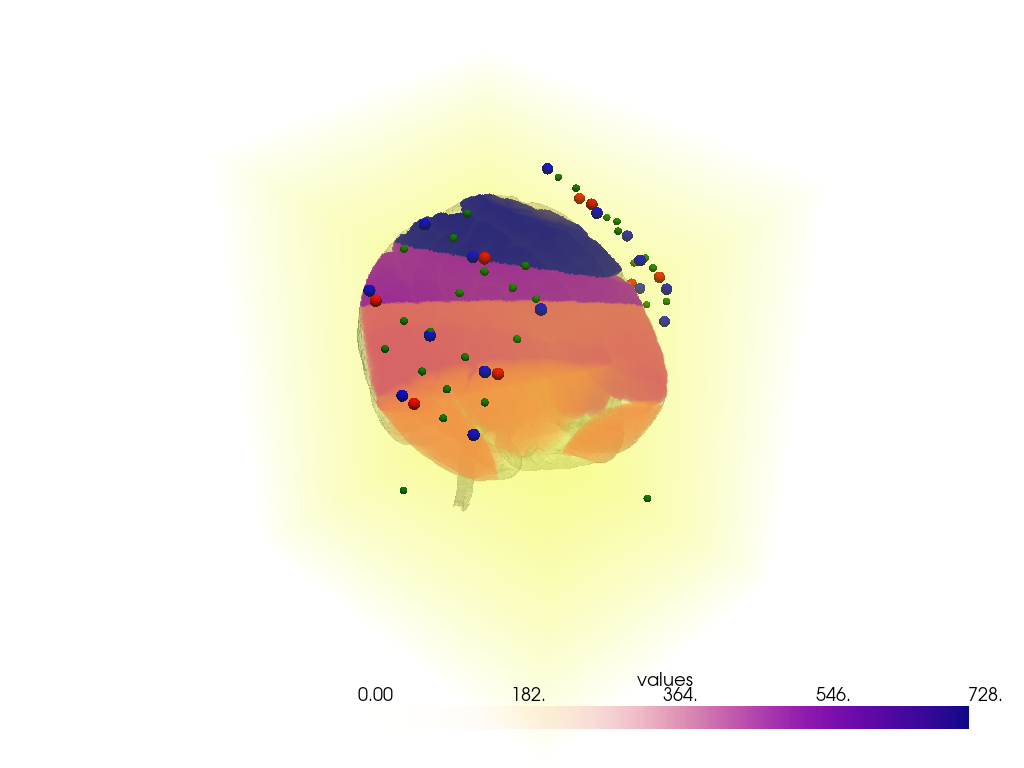

In [16]:
# Plot
plt = pv.Plotter()
vf = pv.wrap(sensitivity)

plt.add_volume(
    vf,
    log_scale=False,
    cmap="plasma_r",
    opacity='sigmoid_5'
)

cedalion.plots.plot_surface(plt, TwoSurfHM.brain, color="w", opacity=0.3)

cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)#, show_labels=False)
plt.show()

### NOT FULLY TESTED: Even further reduce the voxel number (reduce to sensitive voxels only)

In [ ]:
"""
# Even further reduce the voxel number of the head model (reduce to sensitive voxels only)
head_red = head.reduce_voxels_to_sensitivity(Adot, sensitivity_threshold=1e-9)

# adapt forward model and Adot, too
fwm_red = cedalion.imagereco.forward_model.ForwardModel(head_red, geo3d_snapped_ijk, meas_list)
Adot_red = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
"""